## Hyperparameter Tuning of OPE estimators (Part 1; similar policies)

In [1]:
import time
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DoublyRobustWithShrinkage as DRos,
    DoublyRobustWithShrinkageTuning as DRosTuning,
)
from obp.utils import softmax

In [2]:
print(obp.__version__)

0.5.0


In [3]:
## configurations
num_runs = 100
num_data_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]

In [4]:
## define a dataset class
dataset = SyntheticBanditDataset(
    n_actions=10, 
    dim_context=10,
    tau=0.2, 
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)
### training data is used to train an evaluation policy
train_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=5000)
### test bandit data is used to approximate the ground-truth policy value
test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=100000)

In [5]:
## evaluation policy training
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForestClassifier(random_state=12345),
)
ipw_learner.fit(
    context=train_bandit_data["context"], 
    action=train_bandit_data["action"], 
    reward=train_bandit_data["reward"], 
    pscore=train_bandit_data["pscore"], 
)
action_dist_ipw_test = ipw_learner.predict(
    context=test_bandit_data["context"],
)
policy_value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"], 
    action_dist=action_dist_ipw_test, 
)

In [6]:
## evaluation of OPE estimators
se_df_list = []
for num_data in num_data_list:
    se_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## generate validation data
        validation_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ## make decisions on vlidation data
        action_dist_ipw_val = ipw_learner.predict(
            context=validation_bandit_data["context"],
        )

        ## OPE using validation data
        regression_model = RegressionModel(
            n_actions=dataset.n_actions, 
            base_model=LogisticRegression(C=100, max_iter=10000, random_state=12345)
        )
        estimated_rewards = regression_model.fit_predict(
            context=validation_bandit_data["context"], # context; x
            action=validation_bandit_data["action"], # action; a
            reward=validation_bandit_data["reward"], # reward; r
            n_folds=2, # 2-fold cross fitting
            random_state=12345,
        )
        ope = OffPolicyEvaluation(
            bandit_feedback=validation_bandit_data,
            ope_estimators=[
                DRos(lambda_=1, estimator_name="DRos (1)"), 
                DRos(lambda_=100, estimator_name="DRos (100)"), 
                DRos(lambda_=10000, estimator_name="DRos (10000)"),
                DRosTuning(
                    use_bias_upper_bound=False,
                    lambdas=np.arange(1, 10002, 100).tolist(), 
                    estimator_name="DRos (tuning)"
                ), 
            ]
        )
        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=policy_value_of_ipw, # V(\pi_e)
            action_dist=action_dist_ipw_val, # \pi_e(a|x)
            estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}(x,a)
            metric="se", # squared error
        )
        se_list.append(squared_errors)
    ## maximum importance weight in the validation data
    ### a larger value indicates that the behavior and evaluation policies are greatly different
    max_iw = (action_dist_ipw_val[
        np.arange(validation_bandit_data["n_rounds"]), 
        validation_bandit_data["action"], 
        0
    ] / validation_bandit_data["pscore"]).max()
    tqdm.write(f"maximum importance weight={np.round(max_iw, 5)}\n")

    ## summarize results
    se_df = DataFrame(DataFrame(se_list).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
    se_df["num_data"] = num_data
    se_df_list.append(se_df)
    tqdm.write("=====" * 15)
    time.sleep(0.5)

# aggregate all results 
result_df = pd.concat(se_df_list).reset_index(level=0)

num_data=100...: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


maximum importance weight=8.6407



num_data=200...: 100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


maximum importance weight=8.6407



num_data=400...: 100%|██████████| 100/100 [00:05<00:00, 17.28it/s]


maximum importance weight=6.32599



num_data=800...: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


maximum importance weight=11.7867



num_data=1600...: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


maximum importance weight=13.29143



num_data=3200...: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


maximum importance weight=13.29143



num_data=6400...: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


maximum importance weight=18.60611



num_data=12800...: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


maximum importance weight=18.60611



num_data=25600...: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


maximum importance weight=18.60611



num_data=51200...: 100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


maximum importance weight=18.60611



## Visualize Results

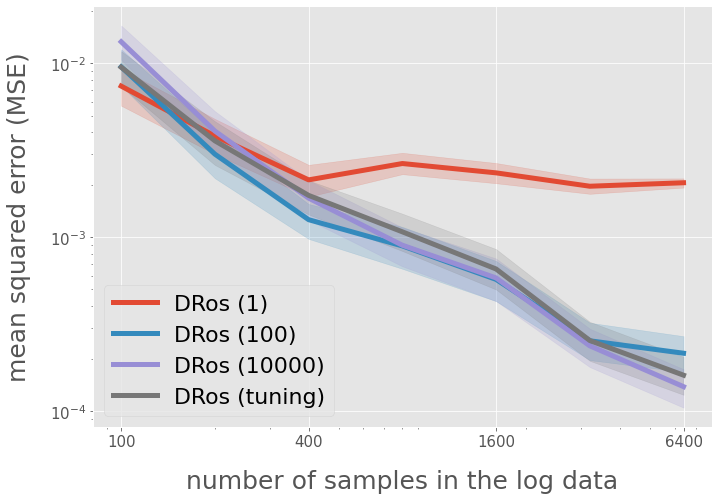

In [7]:
query = "num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(
    ["DRos (1)", "DRos (100)", "DRos (10000)", "DRos (tuning)"], 
    loc="lower left", fontsize=22,
)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.1, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

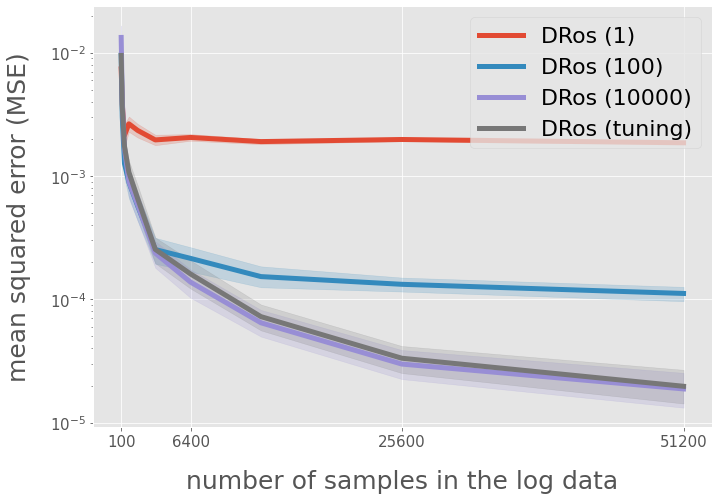

In [8]:
xlabels = [100, 6400, 25600, 51200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df,
)
# title and legend
ax.legend(
    ["DRos (1)", "DRos (100)", "DRos (10000)", "DRos (tuning)"], 
    loc="upper right", fontsize=22,
)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.1, 0.5)
# xaxis
# ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)